## Calibrate camera

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

%matplotlib inline

In [2]:
def calibrate_camera(calib_images_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for fname in calib_images_path:
        img = mpimage.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
    
    return mtx, dist 

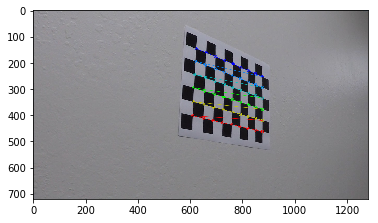

In [3]:
# Make a list of calibration images
calib_images_path = glob.glob('camera_cal/calibration*.jpg')
calib_image = mpimage.imread('camera_cal/calibration1.jpg')

mtx, dist = calibrate_camera(calib_images_path)

In [4]:
import re

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])

    return parts

test_images = [(path, mpimage.imread(path)) for path in 
               sorted(glob.glob('./test_images/test*.jpg'), key=numericalSort)]

In [5]:
def undistort(distorted_image, mtx, dist):
    return cv2.undistort(distorted_image, mtx, dist, None, mtx)

def demo_undistort(original, mtx, dist):    
    undistorted = undistort(original, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    ax1.imshow(original)
    ax1.set_title("Original Image", fontsize=20)
    
    ax2.imshow(undistorted)
    ax2.set_title("Undistorted Image", fontsize=20)
    
    plt.show()

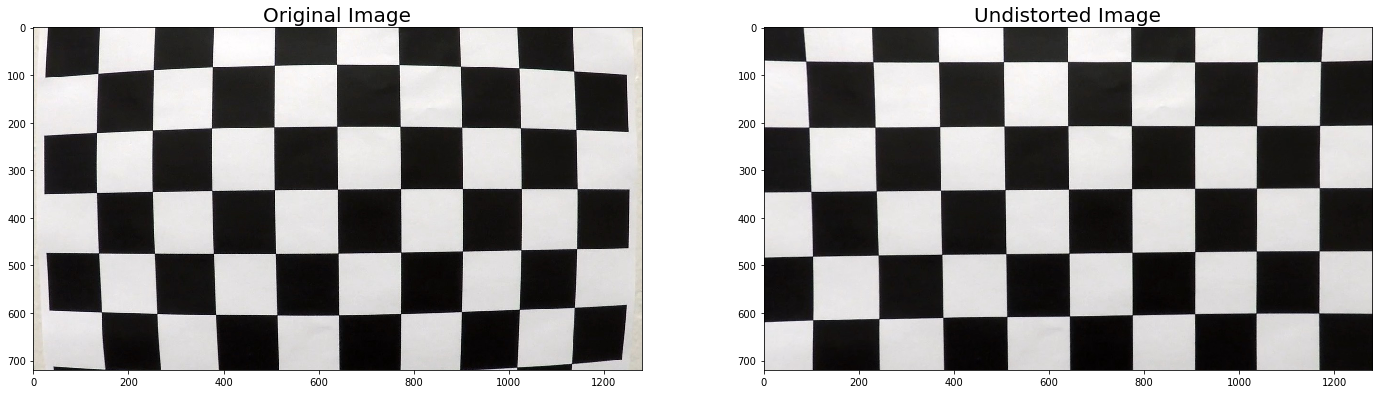

In [6]:
demo_undistort(calib_image, mtx, dist)

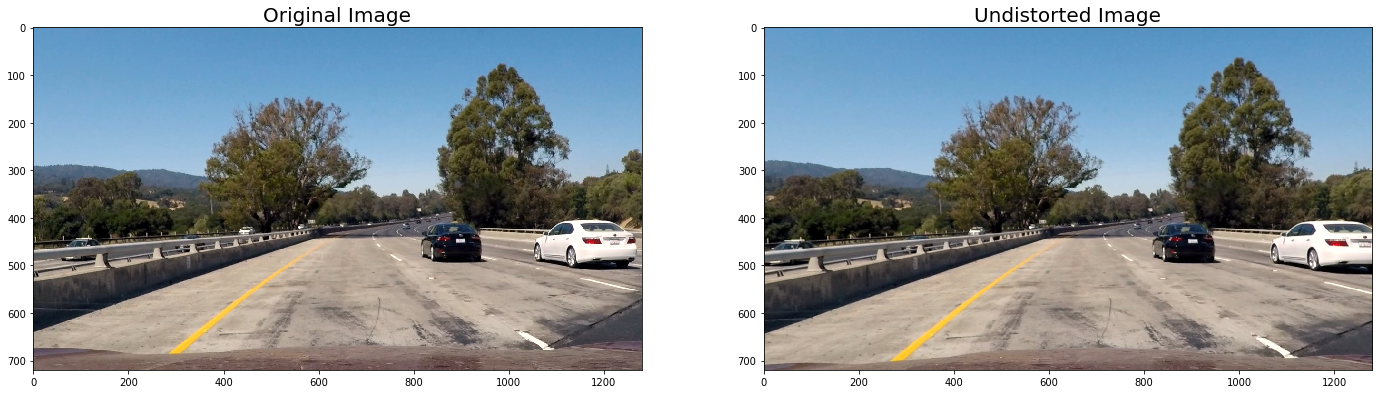

In [7]:
demo_undistort(test_images[0][1], mtx, dist)

In [8]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100), R_thresh=(5, 255), sobel_kernel = 3):    
    # Pull R
    R = img[:,:,0]
    
    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R > R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((R_binary == 1)) & ((sx_binary == 1) | (s_binary == 1))] = 1    
    
    return combined_binary

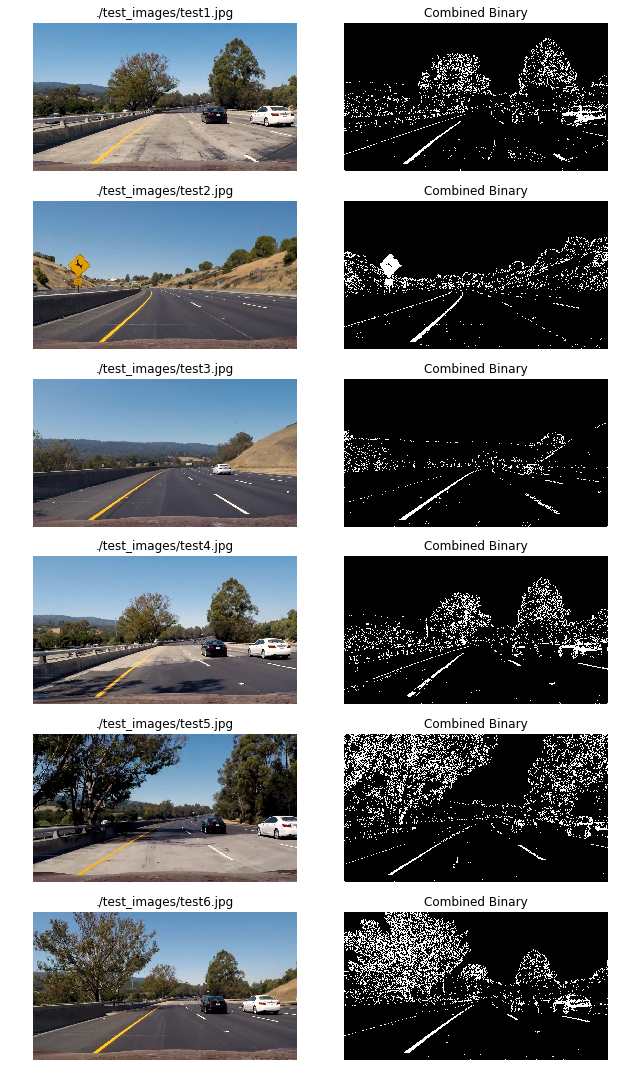

In [9]:
def demo_apply_threshold(images):    
    f, axis = plt.subplots(6, 2, figsize=(8, 16))
    axis = axis.ravel()
    f.tight_layout()

    for i in range(0, len(images)):
        image = images[i][1]
        binary = apply_threshold(image)
        
        axis[i*2].axis('off')
        axis[i*2].imshow(image)
        axis[i*2].set_title(images[i][0], fontsize=12)

        axis[i*2+1].axis('off')
        axis[i*2+1].imshow(binary, cmap='gray')
        axis[i*2+1].set_title('Combined Binary', fontsize=12)    
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

demo_apply_threshold(test_images)

In [10]:
def warper(image, src, dst):
    h, w = image.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, (w,h))
    
    return warped, M, Minv

def draw_border(img, points):
    corners = [tuple(p) for p in points]
    cv2.line(img, corners[0], corners[1], color=[255,0,0], thickness=3)
    cv2.line(img, corners[1], corners[2], color=[255,0,0], thickness=3)
    cv2.line(img, corners[2], corners[3], color=[255,0,0], thickness=3)
    cv2.line(img, corners[3], corners[0], color=[255,0,0], thickness=3)    

def birds_eye_view(image, mtx, dist):
    # Get binary thresholded image
    binary = apply_threshold(image)
 
    # Undistort the image using calibration params found earlier
    undistorted = undistort(binary, mtx, dist)
    
    # Do perspective transform
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])   
    
    # Source points - defined area of lane line edges
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])

    # 4 destination points to transfer
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    
    unwarped, M, Minv = warper(binary, src, dst)    
    
    return binary, unwarped, M, Minv, src, dst

In [11]:
def demo_birds_eye_view(images, mtx, dist):
    f, axis = plt.subplots(2, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    
    axis = axis.ravel()
    
    for i in range(0, len(images)):
        binary, binary_warped, M, Minv, src, dst = birds_eye_view(images[i][1], mtx, dist)
    
        binary = 255 * np.dstack((binary, binary, binary))
        binary_warped = 255 * np.dstack((binary_warped, binary_warped, binary_warped))
    
        draw_border(binary, src)
        draw_border(binary_warped, dst)
        
        axis[i].axis('off')      
        axis[i].imshow(binary_warped)
        axis[i].set_title(images[i][0], fontsize=20)
    plt.show()

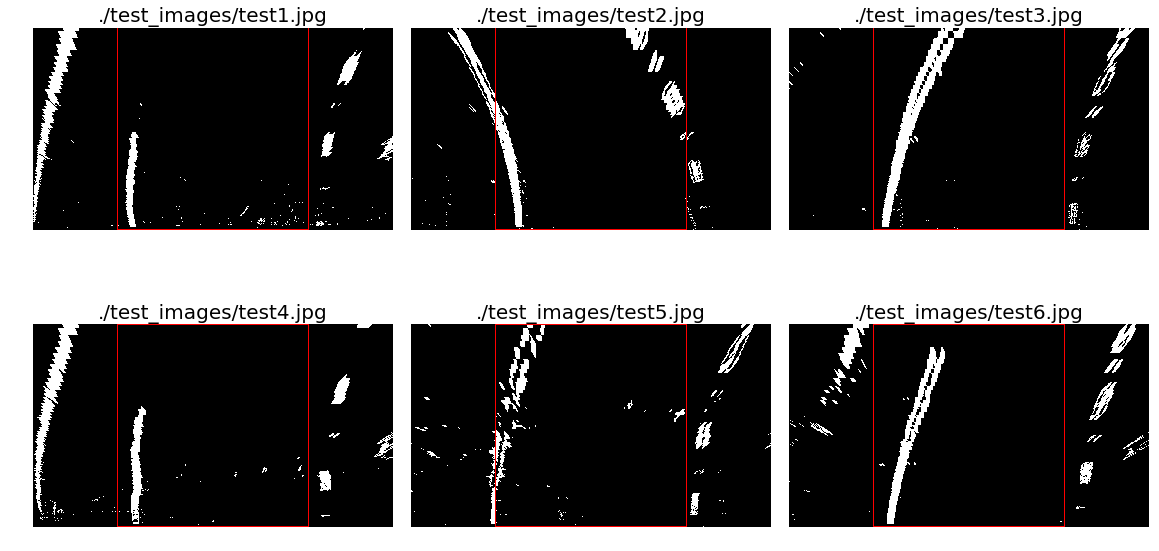

In [12]:
demo_birds_eye_view(test_images, mtx, dist)

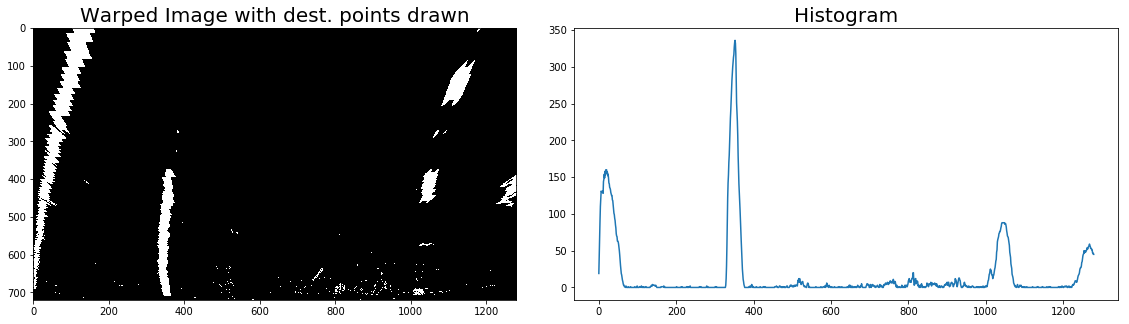

In [13]:
import numpy as np

img = mpimage.imread('./test_images/straight_lines1.jpg')
_, binary_warped, _,_,_,_ = birds_eye_view(test_images[0][1], mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.subplots_adjust(hspace = .2, wspace=.05)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped Image with dest. points drawn', fontsize=20)

ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)

plt.show()

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def first_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit, out_img

(720, 0)

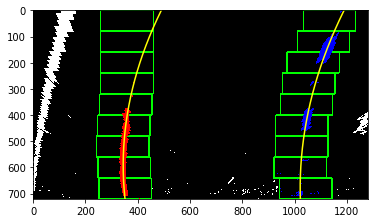

In [15]:
left_lane_inds, left_fit, right_lane_inds, right_fit, out_img = first_lines(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [30]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


def second_ord_poly(line, val):
    a = line[0]
    b = line[1]
    c = line[2]
    formula = (a*val**2)+(b*val)+c

    return formula

In [16]:
def fit_lane(binary_warped, left_fit, right_fit):    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [17]:
def demo_fit_lane(binary_warped, left_fit, right_fit):
    left_fit, right_fit = fit_lane(binary_warped, left_fit, right_fit)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
demo_fit_lane(binary_warped, left_fit, right_fit)

1223.27626099 1734.33969361


In [26]:
def calc_curvature(binary_warped, ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Generate x and y values for plotting    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_fitx, left_curverad, right_fitx, right_curverad

In [19]:
def calc_position_from_center(left_fit, right_fit, y_eval):
    midx = 650
    
    x_left_pix = second_ord_poly(left_fit, y_eval)
    x_right_pix = second_ord_poly(right_fit, y_eval)
    
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    
    return position_from_center

def draw_lane(img, binary_warped, Minv, left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    
    left_fitx, left_curverad, right_fitx, right_curverad = calc_curvature(binary_warped, ploty, left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        
    position_from_center = calc_position_from_center(left_fit, right_fit, y_eval)
    
    texts = [
        'Radius of Curvature (Left): %.2fm' % left_curverad,
        'Radius of Curvature (Right): %.2fm' % right_curverad,
        'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), 
                                            'left' if position_from_center < 0 else 'right')
    ]
    
    for i, txt in zip(range(0, len(texts)), texts):
        cv2.putText(result, txt, (20, 40 + i * 40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 3)
    
    return result

In [24]:
class ImageProcessor:
    def __init__(self):
        self.detected = False
        self.left_fit = None
        self.right_fit = None        

    def process_image(self, img):   
        _, binary_warped, _, Minv,_,_ = birds_eye_view(img, mtx, dist)

        if not self.detected:
            self.detected = True
            _, self.left_fit, _, self.right_fit, _ = first_lines(binary_warped)
        else:
            self.left_fit, self.right_fit = fit_lane(binary_warped, self.left_fit, self.right_fit)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        result = draw_lane(img, binary_warped, Minv, self.left_fit, self.right_fit, ploty)

        return result

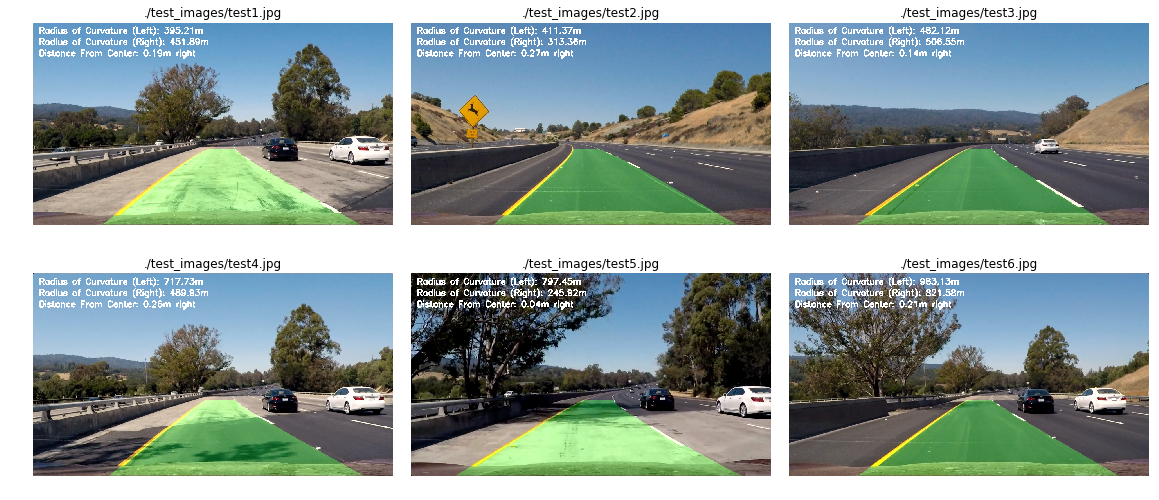

In [31]:
def demo_process_image(images):
    f, axis = plt.subplots(2, 3, figsize=(20,9))
    f.subplots_adjust(hspace = .05, wspace=.05)
    
    axis = axis.ravel()
    
    for i in range(0, len(images)):
        image_processor = ImageProcessor()      
        result = image_processor.process_image(images[i][1])
        
        axis[i].axis('off')      
        axis[i].imshow(result)
        axis[i].set_title(images[i][0], fontsize=12)
    plt.show()
    
demo_process_image(test_images)

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

image_processor = ImageProcessor()

# Reset
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(8,12)
white_clip = clip1.fl_image(image_processor.process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 5min 7s, sys: 9.95 s, total: 5min 17s
Wall time: 2min 19s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
challenge_output = 'challenge_video_result.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")#.subclip(38,43)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))